In [1]:
import sys, os

import random
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import copy

%matplotlib inline

import nilmtk

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import adinilm.functions as F
from adinilm.enumerations import *
from adinilm.objs import DatasetProfile, ProfileHandler, NormalizationHandler
from adinilm.utils import paths_manager as pathsman
from adinilm.io import NilmtkSubsectionExtractor
from adinilm.io.profile import GenericProfileHandler

In [3]:
SAVE_PROFILE = True

In [4]:
sections = ["train", "test", "val"]

In [5]:
## Variable declaration for dataset
TRAIN_UKDALE_BUILDING = 1
TRAIN_UKDALE_START_TIME = "2015-01-01"
TRAIN_UKDALE_END_TIME = "2015-10-20"

TEST_UKDALE_BUILDING = 1
TEST_UKDALE_START_TIME = "2015-11-01"
TEST_UKDALE_END_TIME = "2016-04-30"

VAL_UKDALE_BUILDING = 1
VAL_UKDALE_START_TIME = "2016-11-01"
VAL_UKDALE_END_TIME = "2016-12-31"

FRIDGE_FREEZER = "fridge"
KETTLE = "kettle"
DISHWASHER = "dish washer"
MICROWAVE = "microwave"
WASHER_DRYER = "washer dryer"

applist = [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE]

In [6]:
info = {
        "subsection" : {
                "building" : TRAIN_UKDALE_BUILDING,
                "start_time" : TRAIN_UKDALE_START_TIME,
                "end_time": TRAIN_UKDALE_END_TIME
        },
        "preprocessing" : {
                "sampling" : {
                        "sample_period" : 6,
                        "resample" : True
                },
                "normalization" : {
                        "mode" : "minmax",
                        "scope" : "local"
                }
        },
        "appliances" : [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE],
        "appliance_data" : {
                FRIDGE_FREEZER : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                WASHER_DRYER : {               
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                KETTLE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                DISHWASHER : {
                        "window" : 10,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                MICROWAVE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                }
        }
}

In [7]:
ext = NilmtkSubsectionExtractor(dataset_path=pathsman.UKDALE_H5_PATH, params=info, match_timeframes=True)

c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is s

In [8]:
test_info = copy(info)
test_info["subsection"]["building"] = TEST_UKDALE_BUILDING
test_info["subsection"]["start_time"] = TEST_UKDALE_START_TIME
test_info["subsection"]["end_time"] = TEST_UKDALE_END_TIME

ext2 = NilmtkSubsectionExtractor(dataset_path=pathsman.UKDALE_H5_PATH, params=test_info, match_timeframes=True)

c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is s

In [9]:
val_info = copy(info)
val_info["subsection"]["building"] = VAL_UKDALE_BUILDING
val_info["subsection"]["start_time"] = VAL_UKDALE_START_TIME
val_info["subsection"]["end_time"] = VAL_UKDALE_END_TIME

ext3 = NilmtkSubsectionExtractor(dataset_path=pathsman.UKDALE_H5_PATH, params=val_info, match_timeframes=True)

c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is s

In [10]:
ext_data = {
        "train" : ext,
        "test"  : ext2,
        "val"   : ext3
}

In [11]:
FS = 1/6          # 1 Hz
DUR = 600       # 512 sec

In [12]:
SAMPLE_LENGTH = int(DUR * FS)

In [13]:
def quantile_filter_2(data, sequence_length, p=50):
    new_mains = F.scan_sequences(data=data, mode="odd_window", seq_len=sequence_length)
    new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
    return new_mains

In [14]:
class SequenceToArrayFormatter:

        def __init__(self, info: list):
                self.info = info
        
        def format(self, data : pd.DataFrame, *args, **kwargs) -> np.ndarray:
                finder = kwargs.get() if "finder" in kwargs else "power_series"
                data = data.loc[self.info["appliances"], finder]

                lens = [len(r) for r in data]
                min_lens = min(lens)
                p = [np.array(r)[:min_lens] for r in data]
                data = np.vstack(p)
                data[np.isnan(data)] = 0
                return data.T
        
        def __call__(self, data, *args, **kwargs):
                return self.format(data, *args, **kwargs)

In [15]:
class QuantileFilterApplier:

        def __init__(self, info, p=50):
                self.info = info
                self.p = p
        
        def filter(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[:,i] = quantile_filter_2(data[:,i], self.info["appliance_data"][app]["window"], p=self.p)
                return data_c

        def __call__(self, data, *args, **kwargs):
                return self.filter(data, *args, **kwargs)

In [16]:
class AdaptiveMinMaxScaling:
    
        def __init__(self, info):
                self.info = info

        def normalize(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[:,i] = F.adaptive_minmax_scaling(data[:,i])
                
                return data_c

        def __call__(self, data, *args, **kwargs):
                return self.normalize(data, *args, **kwargs)


In [17]:
class OnPowerThresholdBinarizer:
        def __init__(self, info):
                self.info = info
        
        def binarize(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[:,i] = F.binarization(data[:,i], mode="threshold", threshold=self.info["appliance_data"][app]["on_power_threshold"])
                return data_c
        
        def __call__(self, data, *args, **kwargs):
                return self.binarize(data, *args, **kwargs)

In [18]:
class SubmeterMixer:

        def __init__(self, *args, **kwargs):
                self.ax = kwargs.get("axis") if "axis" in kwargs else 1

        def mix(self, data : np.ndarray, *args, **kwargs):
                return data.sum(axis=self.ax)

        def __call__(self, data, *args, **kwargs):
                return self.mix(data, *args, **kwargs)

In [19]:
class NoisedInput:

        def noise(self, data, *args, **kwargs):
                _denoise = quantile_filter_2(data, 10, 50)
                data = data - np.percentile(data, 1)
                data = np.where(data < _denoise, _denoise, data)
                return quantile_filter_2(data, 10, 50)

        def __call__(self, data, *args, **kwargs):
                return self.noise(data, *args, **kwargs)

In [20]:
formatter = SequenceToArrayFormatter(ext.params)
filterer = QuantileFilterApplier(ext.params)
normalizer = AdaptiveMinMaxScaling(ext.params)
binarizer = OnPowerThresholdBinarizer(ext.params)
mixer = SubmeterMixer(axis=1)
noiser = NoisedInput()

In [42]:
ProfileHandler.mkdir(pathsman.PROFILES_DIR, exist_ok=True)
prof = DatasetProfile(parent_dir=pathsman.PROFILES_DIR,
                handler=NILMProjects.UNETNILM.value,
                dataset_name="ukdale",
                metadata=info,
                mode="w")
prof_handler = GenericProfileHandler(pathsman.PROFILES_DIR)

In [43]:
# Pipeline Workflow

for key, value in ext_data.items():

        data = formatter(train.df)
        data_i = mixer(data)
        data_i_den = quantile_filter_2(data_i, 10, p=50)
        data_i_den = F.adaptive_minmax_scaling(data_i_den)
        data_i_n = noiser(data_i)
        data_i_n = F.adaptive_minmax_scaling(data_i_n)
        data = filterer(data)
        data_p = normalizer(data)
        data_s = binarizer(data)

        assert not np.any(np.isnan(data_i_den))
        assert not np.any(np.isnan(data_i_n))
        assert not np.any(np.isnan(data_p))
        assert not np.any(np.isnan(data_s))

        if SAVE_PROFILE:
                prof_handler.write(data_i_den, data_i_n, data_p, data_s, profile=prof, subdir=key)

                # del data
                # del data_i
                # del data_i_den
                # del data_i_n
                # del data_p
                # del data_s

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_48604\361044578.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_48604\361044578.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_48604\361044578.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes

In [44]:
data_s

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [45]:
data_p[np.isnan(data_p)] = 0

In [46]:
data_p

array([[0.        , 0.        , 0.00041339, 0.00041   , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.00041   , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.00041   , 0.00063492],
       ...,
       [0.        , 0.        , 0.00041339, 0.        , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.        , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.        , 0.00063492]],
      dtype=float32)

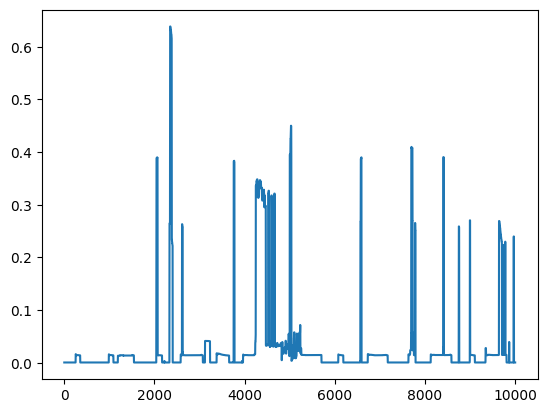

In [47]:
plt.plot(data_i_n[60000:70000])

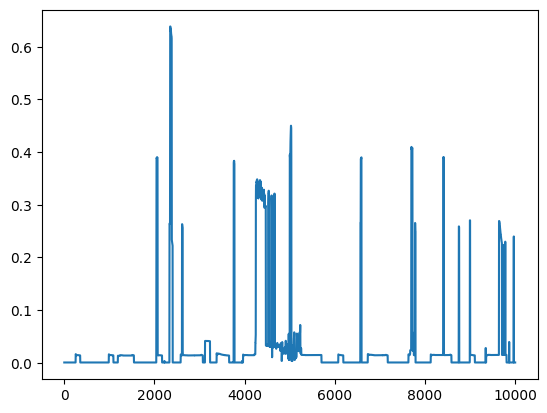

In [48]:
plt.plot(data_i_den[60000:70000])

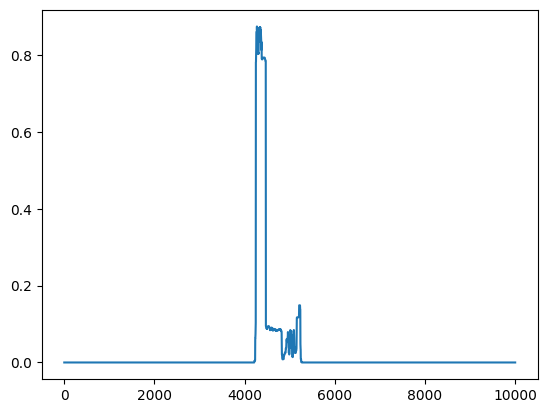

In [49]:
plt.plot(data_p[60000:70000,1])

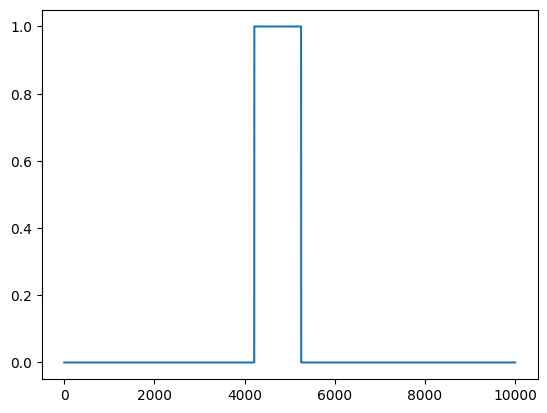

In [50]:
plt.plot(data_s[60000:70000,1])

In [51]:
# if SAVE_PROFILE:
#         ProfileHandler.mkdir(pathsman.PROFILES_DIR, exist_ok=True)
#         prof = DatasetProfile(parent_dir=pathsman.PROFILES_DIR,
#                         handler=NILMProjects.UNETNILM.value,
#                         dataset_name="ukdale",
#                         metadata=info,
#                         mode="w")
#         ret = ProfileHandler.write(data_i_den, data_i_n, data_p, data_s, profile=prof, subdir="training")
#         print(ret)